# 2SFCA script test at Middle Layer Super Output Areas (MSOA) level

In [33]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np

# Data import

## Get MSOA boundary data

In [34]:
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')

<AxesSubplot:>

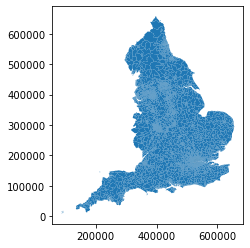

In [35]:
MSOA.plot()

## Get the centroid of MSOA (demand points)

In [36]:
MSOA_points=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Population_Weighted_Centroids_with_population.gpkg?raw=true')
MSOA_points = MSOA_points.to_crs('epsg:27700')

<AxesSubplot:>

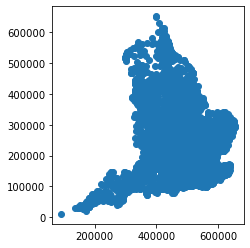

In [37]:
MSOA_points.plot()

### Calculate population over 70

In [44]:
MSOA_points['pop70+'] = MSOA_points['pop70-79'] + MSOA_points['pop80-89'] + MSOA_points['pop90+']

In [45]:
MSOA_points

,objectid,msoa11cd,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,pop70+
0,1,E02002536,5688,1416,1132,891,540,104,9771,POINT (445582.345 524175.434),1535
1,2,E02002537,5578,1251,836,545,386,45,8641,POINT (446777.151 524256.841),976
2,3,E02002534,2547,824,863,967,407,85,5693,POINT (461356.929 515118.900),1459
3,4,E02002535,4959,1636,1385,870,416,70,9336,POINT (446117.027 525455.836),1356
4,5,E02002532,3783,970,810,655,342,95,6655,POINT (461053.212 516175.379),1092
...,...,...,...,...,...,...,...,...,...,...,...
6786,6787,E02004669,3697,1171,1156,946,433,93,7496,POINT (393469.114 227500.260),1472
6787,6788,E02006096,3893,1086,805,804,344,69,7001,POINT (332829.367 109219.836),1217
6788,6789,E02003088,4007,1257,1230,1194,577,179,8444,POINT (343276.340 158947.520),1950
6789,6790,E02006070,5161,1163,906,670,316,75,8291,POINT (331710.269 136880.200),1061


## read vaccination site point data (supply points)

In [39]:
site = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/site_2_26_clean/vaccination_site.gpkg?raw=true')
site = site.to_crs('epsg:27700')

<AxesSubplot:>

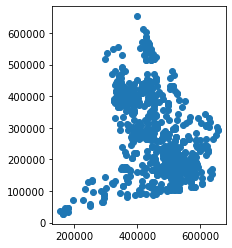

In [40]:
site.plot()

In [41]:
site

,index,supply_value,geometry
0,0,1,POINT (504748.029 248914.642)
1,1,1,POINT (505059.230 222903.988)
2,2,1,POINT (532504.110 176066.629)
3,3,1,POINT (532504.110 176066.629)
4,4,1,POINT (504396.617 222557.941)
...,...,...,...
1595,1595,1,POINT (196928.058 72385.978)
1596,1596,1,POINT (524814.936 172019.963)
1597,1597,1,POINT (526813.753 181129.037)
1598,1598,1,POINT (408626.628 90816.439)


There are 555158 pairs of distances that meet the requirement.

# Read in the driving distance from the point of demand to the point of supply as cost

In [42]:
distance_cost_df = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_github/distance_cost_final.csv') 
distance_cost_df

,Distance in meter,origin_id,destination_id
0,7681,E02002536,122
1,14506,E02002536,127
2,14764,E02002536,137
3,12744,E02002536,836
4,12605,E02002536,838
...,...,...,...
555153,15948,E02003088,1204
555154,7966,E02006070,1278
555155,21577,E02006679,1176
555156,10890,E02006679,1177


# Create a dataframe for the accessibility calculation using the Driving distance from the point of demand to the point of supply as cost

In [48]:
fca = access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='pop70+',
           supply_df= site,
           supply_index= 'index',
           supply_value=['supply_value'],
           cost_df              = distance_cost_df,
           cost_origin          = 'origin_id',
           cost_dest            = 'destination_id',
           cost_name            = 'Distance in meter',
           neighbor_cost_df     = distance_cost_df,
           neighbor_cost_origin = 'origin_id',
           neighbor_cost_dest   = 'destination_id',
           neighbor_cost_name   = 'Distance in meter')

In [49]:
# Using 2SFCA method,  16093.44 meters (10 miles) is used as service threshold radius to calculate the accessibility
fca.two_stage_fca(name = "2sfca",max_cost = 16093.44)

,2sfca_supply_value
msoa11cd,
E02000001,0.002246
E02000002,0.000393
E02000003,0.000372
E02000004,0.000264
E02000005,0.000375
...,...
E02006930,0.001504
E02006931,0.001633
E02006932,0.000164


## See the result

In [50]:
fca.access_df

,pop70+,2sfca_supply_value
msoa11cd,,
E02000001,1151,0.002246
E02000002,774,0.000393
E02000003,954,0.000372
E02000004,822,0.000264
E02000005,677,0.000375
...,...,...
E02006930,488,0.001504
E02006931,843,0.001633
E02006932,115,0.000164


# Show the accessibility result on map

In [51]:
MSOA_fca = pd.merge(left=MSOA, right=fca.access_df, how='left', left_on='MSOA11CD', right_on='msoa11cd')
MSOA_fca=MSOA_fca.fillna(0)
MSOA_fca

,MSOA11CD,MSOA11NM,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,pop70+,2sfca_supply_value
0,E02000001,City of London 001,6206,1339,1025,720,313,118,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",1151,0.002246
1,E02000002,Barking and Dagenham 001,5621,835,505,401,268,105,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",774,0.000393
2,E02000003,Barking and Dagenham 002,8062,1272,886,575,301,78,11174,"POLYGON ((548956.371 189063.484, 549087.474 18...",954,0.000372
3,E02000004,Barking and Dagenham 003,4401,866,598,444,262,116,6687,"POLYGON ((551945.701 186027.855, 551672.764 18...",822,0.000264
4,E02000005,Barking and Dagenham 004,7982,1144,629,413,211,53,10432,"POLYGON ((549420.553 187442.648, 548985.314 18...",677,0.000375
...,...,...,...,...,...,...,...,...,...,...,...,...
6786,E02006930,Greenwich 037,7425,741,473,305,167,16,9127,"POLYGON ((540585.068 178133.897, 540368.424 17...",488,0.001504
6787,E02006931,Greenwich 038,7267,1024,672,510,255,78,9806,"POLYGON ((538775.968 177841.277, 539072.243 17...",843,0.001633
6788,E02006932,Liverpool 060,16963,264,173,80,25,10,17515,"POLYGON ((335757.632 390987.474, 335739.219 39...",115,0.000164
6789,E02006933,Liverpool 061,7130,603,485,220,97,4,8539,"POLYGON ((335096.788 389638.891, 334715.024 38...",321,0.000091


## Use min-max normalization to normalize the accessibility score

In [52]:
MSOA_fca['2sfca_supply_value_normalized'] = (MSOA_fca['2sfca_supply_value']-MSOA_fca['2sfca_supply_value'].min())/(MSOA_fca['2sfca_supply_value'].max()-MSOA_fca['2sfca_supply_value'].min())
MSOA_fca

,MSOA11CD,MSOA11NM,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,pop70+,2sfca_supply_value,2sfca_supply_value_normalized
0,E02000001,City of London 001,6206,1339,1025,720,313,118,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",1151,0.002246,0.977592
1,E02000002,Barking and Dagenham 001,5621,835,505,401,268,105,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",774,0.000393,0.171015
2,E02000003,Barking and Dagenham 002,8062,1272,886,575,301,78,11174,"POLYGON ((548956.371 189063.484, 549087.474 18...",954,0.000372,0.161884
3,E02000004,Barking and Dagenham 003,4401,866,598,444,262,116,6687,"POLYGON ((551945.701 186027.855, 551672.764 18...",822,0.000264,0.114826
4,E02000005,Barking and Dagenham 004,7982,1144,629,413,211,53,10432,"POLYGON ((549420.553 187442.648, 548985.314 18...",677,0.000375,0.163098
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,E02006930,Greenwich 037,7425,741,473,305,167,16,9127,"POLYGON ((540585.068 178133.897, 540368.424 17...",488,0.001504,0.654533
6787,E02006931,Greenwich 038,7267,1024,672,510,255,78,9806,"POLYGON ((538775.968 177841.277, 539072.243 17...",843,0.001633,0.710732
6788,E02006932,Liverpool 060,16963,264,173,80,25,10,17515,"POLYGON ((335757.632 390987.474, 335739.219 39...",115,0.000164,0.071491
6789,E02006933,Liverpool 061,7130,603,485,220,97,4,8539,"POLYGON ((335096.788 389638.891, 334715.024 38...",321,0.000091,0.039409


check the distribution

<AxesSubplot:>

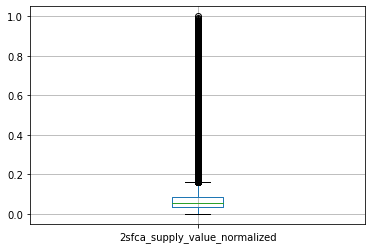

In [53]:
MSOA_fca.boxplot(column='2sfca_supply_value_normalized')

In [54]:
def plot_access(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    #site.plot(ax=base, markersize=1, color='red')

### When the service radius is 10 miles driving distance:

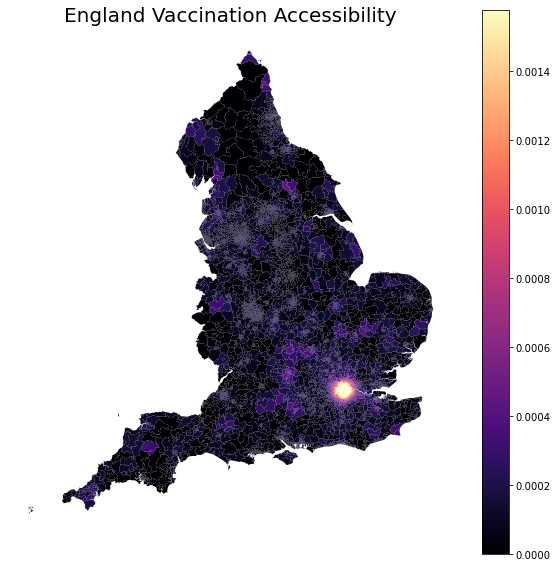

In [55]:
plot_access('2sfca_supply_value')

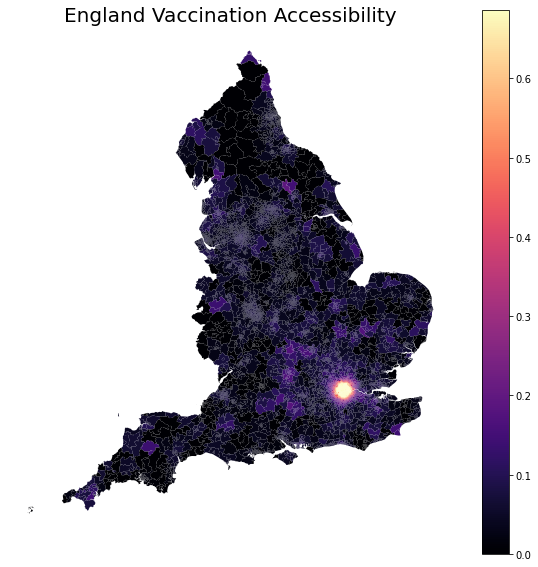

In [56]:
plot_access('2sfca_supply_value_normalized')

## Another way to visulize

In [57]:
def combo(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessbility")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False
        )

### When the service radius is 10 miles:

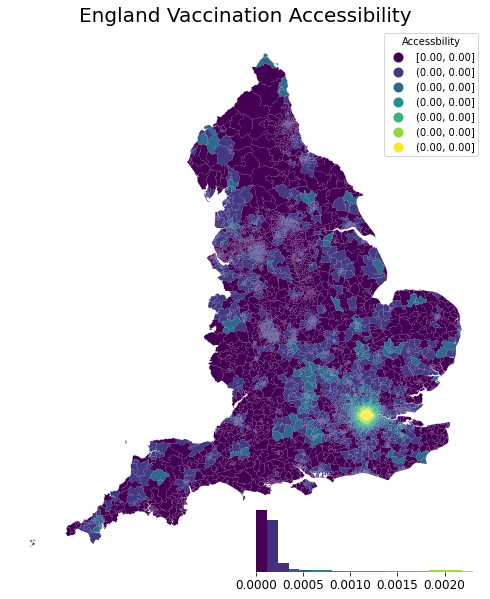

In [58]:
combo('2sfca_supply_value')

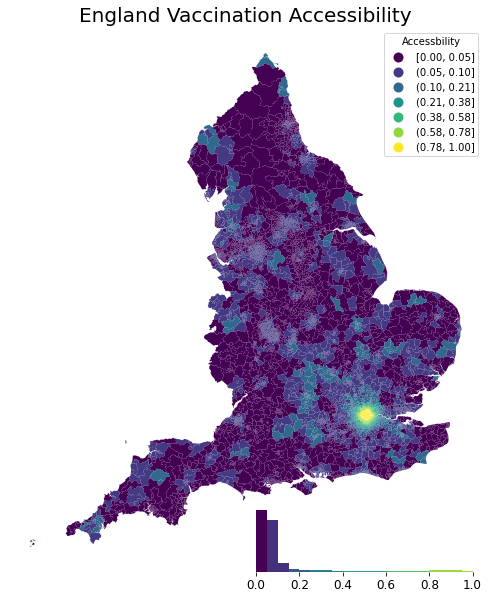

In [59]:
combo('2sfca_supply_value_normalized')

# Plot the vaccination population map

In [60]:
url = 'https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/vaccination_number_2020_12_8_2021_2_21.csv'
vaccination_pop = pd.read_csv(url)

,MSOA_code,under_70,over70-74,over75-79,over80,total
0,E02002796,1083,424,347,450,2304
1,E02002797,1141,516,463,854,2974
2,E02002798,1740,503,307,369,2919
3,E02002799,981,203,156,233,1573
4,E02002800,1091,372,293,516,2272
...,...,...,...,...,...,...
6786,E02002478,846,269,194,208,1517
6787,E02002479,1320,467,428,437,2652
6788,E02002480,817,304,267,317,1705
6789,E02002481,1002,303,225,364,1894


In [62]:
vaccination_pop['over70'] = vaccination_pop['over70-74'] + vaccination_pop['over75-79'] + vaccination_pop['over80']
vaccination_pop

,MSOA_code,under_70,over70-74,over75-79,over80,total,over70
0,E02002796,1083,424,347,450,2304,1221
1,E02002797,1141,516,463,854,2974,1833
2,E02002798,1740,503,307,369,2919,1179
3,E02002799,981,203,156,233,1573,592
4,E02002800,1091,372,293,516,2272,1181
...,...,...,...,...,...,...,...
6786,E02002478,846,269,194,208,1517,671
6787,E02002479,1320,467,428,437,2652,1332
6788,E02002480,817,304,267,317,1705,888
6789,E02002481,1002,303,225,364,1894,892


In [63]:
MSOA_fca = pd.merge(left = MSOA_fca, right=vaccination_pop, how='left', left_on='MSOA11CD', right_on='MSOA_code')

In [65]:
MSOA_fca.head(2)

,MSOA11CD,MSOA11NM,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,pop70+,2sfca_supply_value,2sfca_supply_value_normalized,MSOA_code,under_70,over70-74,over75-79,over80,total,over70
0,E02000001,City of London 001,6206,1339,1025,720,313,118,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",1151,0.002246,0.977592,E02000001,846,295,194,241,1576,730
1,E02000002,Barking and Dagenham 001,5621,835,505,401,268,105,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",774,0.000393,0.171015,E02000002,778,163,156,294,1391,613


In [66]:
MSOA_fca['vaccination_percentage_for70+'] = MSOA_fca['over70']/MSOA_fca['pop70+']

,MSOA11CD,MSOA11NM,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,...,2sfca_supply_value,2sfca_supply_value_normalized,MSOA_code,under_70,over70-74,over75-79,over80,total,over70,vaccination_percentage_for70+
0,E02000001,City of London 001,6206,1339,1025,720,313,118,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",...,0.002246,0.977592,E02000001,846,295,194,241,1576,730,0.634231
1,E02000002,Barking and Dagenham 001,5621,835,505,401,268,105,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",...,0.000393,0.171015,E02000002,778,163,156,294,1391,613,0.791990


In [93]:
# Set vaccination rate greater than 1 to 1
MSOA_fca['vaccination_rate_70+']= np.where(test['vaccination_percentage_for70+']>1, 1, test['vaccination_percentage_for70+'])
MSOA_fca.head(2)

,MSOA11CD,MSOA11NM,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,...,MSOA_code,under_70,over70-74,over75-79,over80,total,over70,vaccination_percentage_for70+,mm,vaccination_rate_70+
0,E02000001,City of London 001,6206,1339,1025,720,313,118,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",...,E02000001,846,295,194,241,1576,730,0.634231,0.634231,0.634231
1,E02000002,Barking and Dagenham 001,5621,835,505,401,268,105,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",...,E02000002,778,163,156,294,1391,613,0.791990,0.791990,0.791990


In [110]:
def plot_access1(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Rate in over 70s by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    #site.plot(ax=base, markersize=1, color='red')

In [112]:
def combo1(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Rate in over 70s by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False
        )

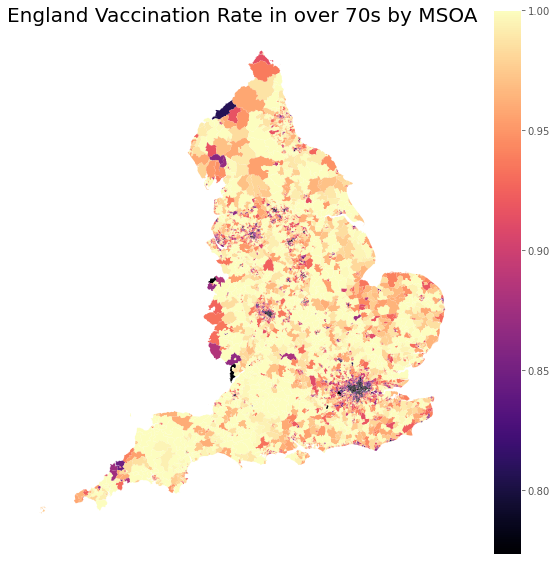

In [113]:
plot_access1('vaccination_rate_70+')

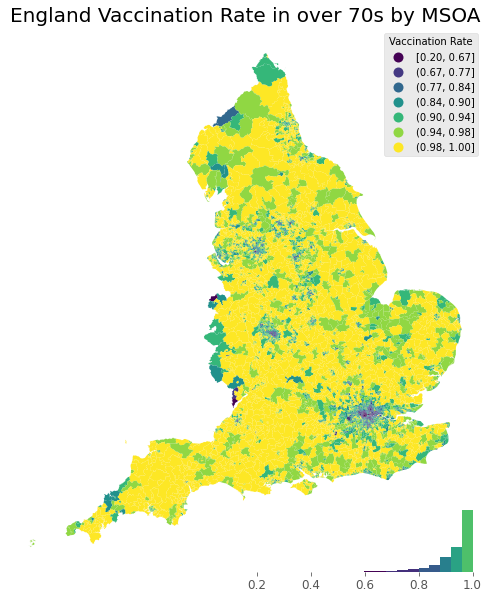

In [114]:
combo1('vaccination_rate_70+')

# Compare with accessibility score map

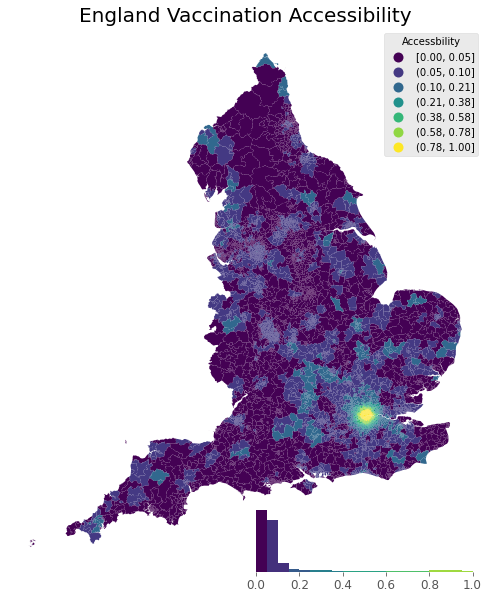

In [106]:
combo('2sfca_supply_value_normalized')

# Calculate Pearson and Spearman correlation coefficient of accessibility and vaccination rate

In [99]:
pearson_correlation_coefficient = MSOA_fca[['2sfca_supply_value_normalized','vaccination_rate_70+']].corr(method='pearson')
pearson_correlation_coefficient

,2sfca_supply_value_normalized,vaccination_rate_70+
2sfca_supply_value_normalized,1.000000,-0.623831
vaccination_rate_70+,-0.623831,1.000000


In [101]:
spearman_correlation_coefficient = MSOA_fca[['2sfca_supply_value_normalized','vaccination_rate_70+']].corr(method='spearman')
spearman_correlation_coefficient

,2sfca_supply_value_normalized,vaccination_rate_70+
2sfca_supply_value_normalized,1.000000,-0.352876
vaccination_rate_70+,-0.352876,1.000000


# draw a scatter plot between accessibility and vaccination rate

In [102]:
plot = pd.DataFrame()
plot['Accessibility'] = MSOA_fca['2sfca_supply_value_normalized']
plot['Vaccination Rate'] = MSOA_fca['vaccination_rate_70+']

Text(0, 0.5, 'Vaccination Rate')

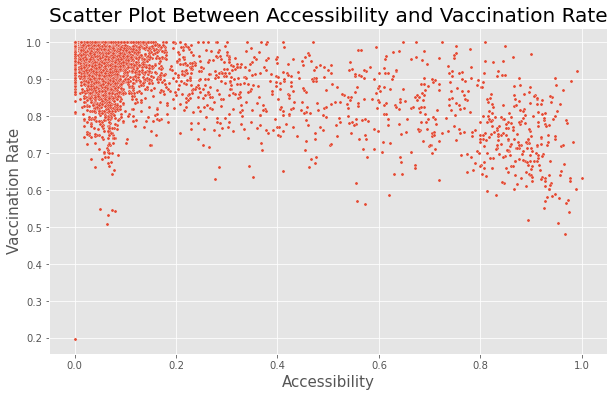

In [103]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
a = sns.scatterplot(data=plot, x="Accessibility", y="Vaccination Rate",s=10)
a.axes.set_title("Scatter Plot Between Accessibility and Vaccination Rate",fontsize=20)
a.set_xlabel("Accessibility",fontsize=15)
a.set_ylabel("Vaccination Rate",fontsize=+15)

Text(0.55, 1.05, 'Pair Plot Between Accessibility and Vaccination Rate')

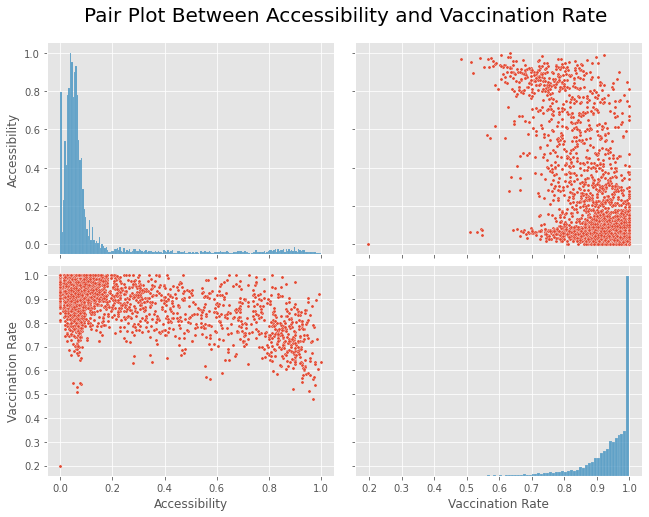

In [104]:
g = sns.pairplot(plot,plot_kws={"s": 10})
g.fig.set_size_inches(10,7)
g.fig.suptitle("Pair Plot Between Accessibility and Vaccination Rate", y=1.05,x=0.55,fontsize=20)
#g.plot_kws={"s": 1}

Text(0, 0.5, 'Vaccination Rate')

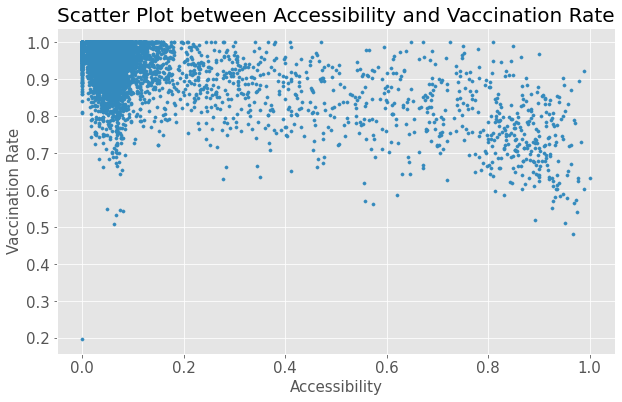

In [105]:
ax1 = plot.plot.scatter(x='Accessibility',
                        y='Vaccination Rate',
                        figsize = (10,6),
                        fontsize = 15,s=10)
plt.title("Scatter Plot between Accessibility and Vaccination Rate",fontsize=20)
plt.xlabel("Accessibility",fontsize=15)
plt.ylabel("Vaccination Rate",fontsize=15)